# Random Forest Regressor With "Sklearn" Library

### Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Loading Data Set

In [2]:
# loading dataset
def getData(strt_date = "2019-01-01", end_date = "2019-12-31"):
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["delta_Open"] = (df.Open - df.Open.shift(periods=1))
    df["delta_Close"] = (df.Close - df.Close.shift(periods=1))
    df["delta_RMW"] = (df.RMW - df.RMW.shift(periods=1))
    df["delta_SMB"] = (df.SMB - df.SMB.shift(periods=1))
    df["delta_MktRF"] = (df["Mkt-RF"] - df["Mkt-RF"].shift(periods=1))
    df["delta_HML"] = (df.HML - df.HML.shift(periods=1))
    df["delta_CMA"] = (df.CMA - df.CMA.shift(periods=1))
    df["delta_Average"] = (df.Average - df.Average.shift(periods=1))
    df = df.dropna().reset_index(drop=True)
    
    df["label"] = df.delta_Open
    df = df.drop("delta_Open", axis=1)
    
    return df

In [3]:
## One year data
df = getData()

## Removing correlated columns
df.columns
df = df.drop(["High","Low","Adj Close"," HC- Open"," HC- High"," HC- Low"," HC- Close"], axis=1)
df.head()

,Date,Open,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Average,Days,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,2019-01-03,90.940002,90.639999,9820200,-2.45,0.52,1.23,-0.25,0.91,0.01,53.531250,2,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.089996
1,2019-01-04,90.839996,92.489998,10565700,3.55,0.39,-0.74,-0.09,-0.58,0.01,52.343750,3,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,-0.100006
2,2019-01-07,91.910004,92.120003,9012500,0.94,0.82,-0.67,-0.70,-0.41,0.01,53.984375,4,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,1.070007
3,2019-01-08,92.699997,92.459999,9551300,1.01,0.44,-0.53,0.35,-0.09,0.01,57.507812,5,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,0.789993
4,2019-01-09,92.690002,90.949997,15015600,0.56,0.51,-0.04,0.09,-0.18,0.01,58.296875,6,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-0.009995


### Tweaking Data set as per requirements

In [4]:
df_x = df.drop("label", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = df[["label"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df.head()

,Date,Open,Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,Average,Days,delta_Close,delta_RMW,delta_SMB,delta_MktRF,delta_HML,delta_CMA,delta_Average,label
0,2019-01-03,90.940002,90.639999,9820200.0,-2.45,0.52,1.23,-0.25,0.91,0.01,53.531250,2.0,-0.639999,-0.12,-0.21,-2.68,0.08,0.65,-0.328125,-0.100006
1,2019-01-04,90.839996,92.489998,10565700.0,3.55,0.39,-0.74,-0.09,-0.58,0.01,52.343750,3.0,1.849998,0.16,-0.13,6.00,-1.97,-1.49,-1.187500,1.070007
2,2019-01-07,91.910004,92.120003,9012500.0,0.94,0.82,-0.67,-0.70,-0.41,0.01,53.984375,4.0,-0.369995,-0.61,0.43,-2.61,0.07,0.17,1.640625,0.789993
3,2019-01-08,92.699997,92.459999,9551300.0,1.01,0.44,-0.53,0.35,-0.09,0.01,57.507812,5.0,0.339996,1.05,-0.38,0.07,0.14,0.32,3.523438,-0.009995
4,2019-01-09,92.690002,90.949997,15015600.0,0.56,0.51,-0.04,0.09,-0.18,0.01,58.296875,6.0,-1.510002,-0.26,0.07,-0.45,0.49,-0.09,0.789062,-1.800003


### Train and Test Data Set

In [5]:
## Train and Test Data
train_start_date = "2019-01-01"
train_end_date =  "2019-10-31"
test_start_date = "2019-11-01"
test_end_date = "2019-12-31"
df_train = df[(df["Date"] >= train_start_date) & (df["Date"] <= train_end_date)]
df_test = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)]
df_train = df_train.drop(["Date","Days","Close","Mkt-RF","SMB","HML","RMW","CMA","Average"], axis=1)
df_test = df_test.drop(["Date","Days","Close","Mkt-RF","SMB","HML","RMW","CMA","Average"], axis=1)

In [6]:
X_train= df_train.drop(["label"],axis=1)
X_test= df_test.drop(["label"], axis=1)
Y_train = df_train[["label"]]
Y_test=df_test[["label"]]

### Model Fitting and Results for Change in Open

In [7]:
regressor = RandomForestRegressor(bootstrap=True, max_depth=2, n_estimators=2, max_features=3, max_samples=150, min_samples_leaf=5)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

### Actual Predictions for Open

In [8]:
predictions = list(Y_pred)
Actual = list(Y_test["label"])
Open_Act = list(df_test["Open"])

df_pred = pd.DataFrame(list(zip(predictions,Actual,Open_Act)), columns = ["Change_Pred","Change_Actual","Open_Act"])
df_pred["Open_pred"] = df_pred.Change_Pred + df_test.Open.shift(1).reset_index(drop=True)
df_pred = df_pred.dropna().reset_index(drop=True)
df_pred.head()

,Change_Pred,Change_Actual,Open_Act,Open_pred
0,0.250018,-0.910004,123.919998,125.080020
1,-0.028816,-5.089996,118.830002,123.891182
2,0.098684,0.269997,119.099999,118.928686
3,0.250018,1.239998,120.339996,119.350016
4,-0.028816,-0.489998,119.849999,120.311180


### Evaluation

In [9]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df_pred.Open_Act, df_pred.Open_pred))
print('Mean Squared Error:', metrics.mean_squared_error(df_pred.Open_Act, df_pred.Open_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_pred.Open_Act, df_pred.Open_pred)))
print('R_2 Error:', metrics.r2_score(df_pred.Open_Act, df_pred.Open_pred))

Mean Absolute Error: 0.7403035522480728
Mean Squared Error: 1.2253443557522687
Root Mean Squared Error: 1.1069527341997347
R_2 Error: 0.7577627130404747


### Feature Selection based on optimum solution

delta_SMB        0.352442
Volume           0.338811
delta_Close      0.161189
delta_HML        0.147558
delta_Average    0.000000
delta_CMA        0.000000
delta_MktRF      0.000000
delta_RMW        0.000000
RF               0.000000
Open             0.000000
dtype: float64


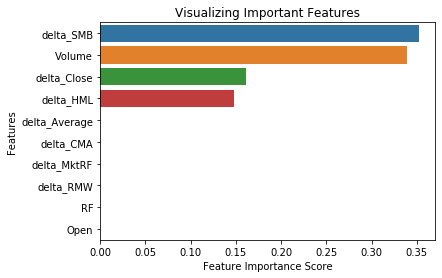

In [10]:
## Feature Selection Importance
imp_feature = pd.Series(regressor.feature_importances_,index = X_train.columns.values).sort_values(ascending=False)
print(imp_feature)

sns.barplot(x=imp_feature, y=imp_feature.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Visualisation

In [11]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

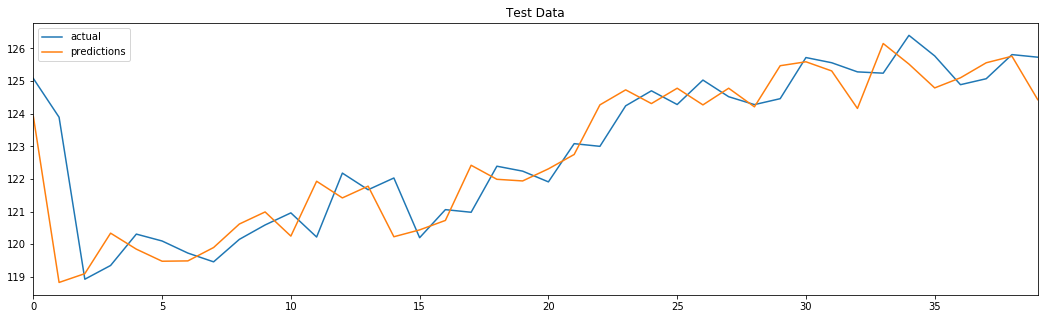

In [12]:
create_plot(df_pred.Open_Act, df_pred.Open_pred,title="Test Data")